# 现代CNN
## 知识点
- 现代CNN的例子
- AlexNet
  - 传统机器学习pipeline（非end-to-end）：
    - 通过传感器收集数据集
    - 手工对数据集进行预处理
    - 通过SIFT/HOG/SURF等特征提取算法，或其他手动设计的流程，来处理数据
    - 将提取的特征输入分类器（基于凸优化的传统方法，如线性模型或核方法）中训练
  - 使用了dropout、大量的图像增强
- VGG
  - 模块化的尝试：寻找重复模式，神经元 -> 层 -> 块
- NiN
  - 卷积层 输入和输出：四维张量，样本x通道x高度x宽度
  - 全连接层 输入和输出：二为张量，样本x特征
  - NiN将每个像素视为样本，将通道维度视为特征，因而使用1x1卷积
  - 没有全连接层
    - 使用NiN块，输出通道数等于标签
    - 最后是一个全局平均pooling层，生成logits
- GoogLeNet
- ResNet
- DenseNet




---

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

'''根据AlexNet的图示'''
net = nn.Sequential(
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(), # 54*54
    nn.MaxPool2d(kernel_size=3, stride=2), # 26*26
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(), # 26*26
    nn.MaxPool2d(kernel_size=3, stride=2), # 12*12
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(), # 12*12
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(), # 12*12
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(), # 12*12
    nn.MaxPool2d(kernel_size=3, stride=2), # 5*5
    nn.Flatten(),
    # 全连接层输出数量很多，使用Dropout层来减轻overfit
    nn.Linear(6400, 4096), nn.ReLU(),
    nn.Dropout(p=0.5), 
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 10) # 使用Fashion-MNIST，因此改为十分类
)

In [2]:
X = torch.randn(1, 1, 224, 224)
for layer in net:
    X = layer(X)
    print(layer._get_name(), 'output shape:\t', X.shape)

Conv2d output shape:	 torch.Size([1, 96, 54, 54])
ReLU output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Conv2d output shape:	 torch.Size([1, 256, 26, 26])
ReLU output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 256, 12, 12])
ReLU output shape:	 torch.Size([1, 256, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 256, 5, 5])
Flatten output shape:	 torch.Size([1, 6400])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1,

loss 0.326, train acc 0.880, test acc 0.880
6342.5 examples/sec on cuda


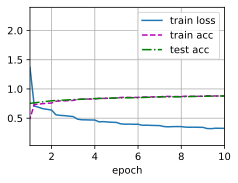

In [3]:
batch_size = 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)

lr, num_epochs = 0.01, 10
device = torch.device('cuda' if torch.cuda.is_available() else 'mps')
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, device)

In [1]:
'''实现一个视觉几何组（VGG）块'''
import torch
from torch import nn
from d2l import torch as d2l

def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels,
                                kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    return nn.Sequential(*layers) # 使用*解包

In [3]:
# 参数：卷积层数目、输出通道数量
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

def vgg(conv_arch):
    '''实现VGG-11'''
    conv_blks = []
    in_channels = 1
    # 卷积层部分
    for(num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels
        
    return nn.Sequential(
        *conv_blks, nn.Flatten(), #VGG块
        nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 10)
    )
    
net = vgg(conv_arch)

In [4]:
X = torch.rand(1, 1, 224, 224)
for blk in net:
    X = blk(X)
    print(blk._get_name(), 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


loss 0.171, train acc 0.938, test acc 0.923
3688.6 examples/sec on cuda:0


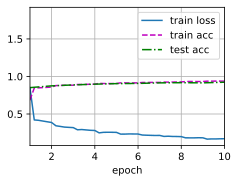

In [11]:
ratio = 4
# 为了加快训练速度，通道数量缩放为原本的1/4
small_conv_arch = [
    (pair[0], pair[1] // ratio) for pair in conv_arch
]
net = vgg(small_conv_arch)

lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [12]:
'''NiN块'''
import torch
from torch import nn
from d2l import torch as d2l

def nin_blocks(in_channels, out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU()
    )


In [ ]:
net = nn.Sequential(
    
)